In [12]:
import cv2
import mediapipe as mp
import numpy as np
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [13]:
model_path = "pose_landmarker_full.task"

# Improved real time body pose detection with 1euro-noise-filtering

## Implementing 1euro-noise-filtering algo

In [14]:
import numpy as np
from time import time

def smoothing_factor(t_e, cutoff):
    r = 2 * np.pi * cutoff * t_e
    return r / (r + 1)


def exponential_smoothing(a, x, x_prev):
    return a * x + (1 - a) * x_prev


class OneEuroFilter:
    def __init__(self, x0, dx0=0.0, min_cutoff=1.0, beta=0.0,
                 d_cutoff=1.0):
        """Initialize the one euro filter."""
        # The parameters.
        self.data_shape = x0.shape
        self.min_cutoff = np.full(x0.shape, min_cutoff)
        self.beta = np.full(x0.shape, beta)
        self.d_cutoff = np.full(x0.shape, d_cutoff)
        # Previous values.
        self.x_prev = x0.astype(np.float64)
        self.dx_prev = np.full(x0.shape, dx0)
        self.t_prev = time()

    def __call__(self, x):
        """Compute the filtered signal."""
        assert x.shape == self.data_shape

        t = time()
        t_e = t - self.t_prev
        t_e = np.full(x.shape, t_e)

        # The filtered derivative of the signal.
        a_d = smoothing_factor(t_e, self.d_cutoff)
        dx = (x - self.x_prev) / t_e
        dx_hat = exponential_smoothing(a_d, dx, self.dx_prev)

        # The filtered signal.
        cutoff = self.min_cutoff + self.beta * np.abs(dx_hat)
        a = smoothing_factor(t_e, cutoff)
        x_hat = exponential_smoothing(a, x, self.x_prev)

        # Memorize the previous values.
        self.x_prev = x_hat
        self.dx_prev = dx_hat
        self.t_prev = t

        return x_hat

## Function to draw body landmarks

In [15]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]
    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Rea-time test: body pose detection with 1euro-noise-filtering

In [16]:
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

cap = cv2.VideoCapture(0)
with PoseLandmarker.create_from_options(options) as pose:
    init = True
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
        results = pose.detect(mp_image)
        
        if len(results.pose_landmarks) != 0:
            coords = np.array([[joint.x, joint.y, joint.z] for joint in results.pose_landmarks[0]])
            if init == True:
                coords_hat = coords.copy()
                
                # The filtered signal
                min_cutoff = 1
                beta = 0
                one_euro_filter = OneEuroFilter(
                    coords,
                    min_cutoff=min_cutoff,
                    beta=beta)
                init = False
            else:
                coords_hat = one_euro_filter(coords)
                
            for i in range(coords.shape[0]):
                results.pose_landmarks[0][i].x = coords_hat[i][0]
                results.pose_landmarks[0][i].y = coords_hat[i][1]
                results.pose_landmarks[0][i].z = coords_hat[i][2]
            
            
        # Recolor back to BGR
        image.flags.writeable = True
    
        
        annotated_image = draw_landmarks_on_image(image, results)
        image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('Mediapipe Feed', image)
        

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

I0000 00:00:1715165000.438995       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2


KeyboardInterrupt: 

# 3D Visualization using Plotly library -> (Static not for real-time visualization)

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [18]:
_PRESENCE_THRESHOLD = 0
_VISIBILITY_THRESHOLD = 0


def plot_landmarks(
    landmark_list,
    connections=None,
):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list):
        if (
            landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        out_cn = []
        num_landmarks = len(landmark_list)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {"xs": [], "ys": [], "zs": []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: "z", 1: "x", 2: "y"})
    df["lm"] = df.index.map(lambda s: mp_pose.PoseLandmark(s).name).values
    fig = (
        px.scatter_3d(df, x="z", y="x", z="y", hover_name="lm")
        .update_traces(marker={"color": "red"})
        .update_layout(
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
            scene={"camera": {"eye": {"x": 2.1, "y": 0, "z": 0}}},
        )
    )
    fig.add_traces(
        [
            go.Scatter3d(
                x=cn2["xs"],
                y=cn2["ys"],
                z=cn2["zs"],
                mode="lines",
                line={"color": "black", "width": 5},
                name="connections",
            )
        ]
    )

    return fig

In [19]:
# Initializing the Mediapipe poselandmarker
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

pose = PoseLandmarker.create_from_options(options)

I0000 00:00:1715165012.473215       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2


In [20]:
image = cv2.imread("images_and_videos/image.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
results = pose.detect(mp_image)

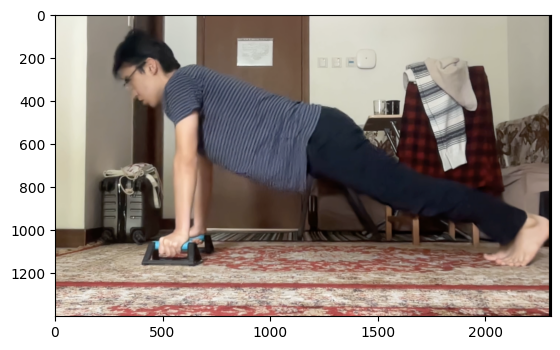

In [21]:
plt.imshow(image)

In [22]:
plot_landmarks(results.pose_world_landmarks[0],  mp_pose.POSE_CONNECTIONS)

# Real time 3D visualization with Open3D

## Without using 1euro-noise-filtering

In [23]:
import open3d as o3d
import numpy as np

In [24]:
def create_3d_grid(size=1, n=10, color=[0, 0.5, 0.5]):
    """Create a 3D grid consisting of three planes joined at the origin."""
    lines = []
    points = []
    line_color = []

    # Create grid along the X-axis
    for i in range(-n, n + 1):
        y = i * size
        start_idx = len(points)
        points.append([-n * size, y, 0])
        points.append([n * size, y, 0])
        lines.append([start_idx, start_idx + 1])
        line_color.append(color)

    # Create grid along the Y-axis
    for i in range(-n, n + 1):
        x = i * size
        start_idx = len(points)
        points.append([x, -n * size, 0])
        points.append([x, n * size, 0])
        lines.append([start_idx, start_idx + 1])
        line_color.append(color)

    # Create grid along the Z-axis
    for i in range(-n, n + 1):
        x = i * size
        start_idx = len(points)
        points.append([x, 0, -n * size])
        points.append([x, 0, n * size])
        lines.append([start_idx, start_idx + 1])
        line_color.append(color)

    # Create a LineSet from the points and lines
    grid = o3d.geometry.LineSet()
    grid.points = o3d.utility.Vector3dVector(points)
    grid.lines = o3d.utility.Vector2iVector(lines)
    grid.colors = o3d.utility.Vector3dVector(line_color)

    return grid

In [25]:
PRESENCE_THRESHOLD = 0.
VISIBILITY_THRESHOLD = 0.

def plot_landmarks_open3d_real_time(results, connections, vis, grid):
    if results == None:
        return None
    if len(results.pose_world_landmarks) == 0:
        return None
    if not results.pose_world_landmarks[0]:
        return None
    
    landmark_list = results.pose_world_landmarks[0]
    points = []
    colors = []
    plotted_landmarks = {}
    index_mapping = {}
    for idx, landmark in enumerate(landmark_list):
        if (
            landmark.visibility < VISIBILITY_THRESHOLD
        ) or (
            landmark.presence < PRESENCE_THRESHOLD
        ):
            continue
        new_index = len(points)
        index_mapping[idx] = new_index
        plotted_landmarks[idx] = (landmark.x, -landmark.y, landmark.z)
        points.append((landmark.x, -landmark.y, landmark.z))
        colors.append([1, 0, 0])

    lines = []    
    if connections:
        num_landmarks = len(landmark_list)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                new_start_idx = index_mapping[start_idx]
                new_end_idx = index_mapping[end_idx]
                lines.append([new_start_idx, new_end_idx])

    # Create Open3D structures for visualization
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(points)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector([[0, 0, 0] for _ in lines])  # Black color for lines

    vis.clear_geometries()
    vis.get_render_option().point_size = 10.0
    
    vis.add_geometry(pcd)
    vis.add_geometry(line_set)
    vis.add_geometry(grid)
    

    return 

In [26]:
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

cap = cv2.VideoCapture("images_and_videos/from_side.mp4")
with PoseLandmarker.create_from_options(options) as pose:
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    grid = create_3d_grid(size=0.1, n=10, color=[0, 0.5, 0.5])

    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
        results = pose.detect(mp_image)
        

        # Recolor back to BGR
        image.flags.writeable = True
    
        
        annotated_image = draw_landmarks_on_image(image, results)
        image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('Mediapipe Feed', image)
        
        #3D animation in open3D
        plot_landmarks_open3d_real_time(results,  mp_pose.POSE_CONNECTIONS, vis, grid)   
        
        vis.poll_events()
        vis.update_renderer()  

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

I0000 00:00:1715165021.710165       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


KeyboardInterrupt: 

## Using 1euro-noise-filtering

In [11]:
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

cap = cv2.VideoCapture("images_and_videos/from_side.mp4")
with PoseLandmarker.create_from_options(options) as pose:
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    grid = create_3d_grid(size=0.1, n=10, color=[0, 0.5, 0.5])
    init = True
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
        results = pose.detect(mp_image)

        #1euro-noise-filter
        if len(results.pose_landmarks) != 0:
            coords = np.array([[joint.x, joint.y, joint.z] for joint in results.pose_landmarks[0]])
            if init == True:
                coords_hat = coords.copy()
                
                # The filtered signal
                min_cutoff = 1
                beta = 0
                one_euro_filter = OneEuroFilter(
                    coords,
                    min_cutoff=min_cutoff,
                    beta=beta)
                init = False
            else:
                coords_hat = one_euro_filter(coords)
                
            for i in range(coords.shape[0]):
                results.pose_landmarks[0][i].x = coords_hat[i][0]
                results.pose_landmarks[0][i].y = coords_hat[i][1]
                results.pose_landmarks[0][i].z = coords_hat[i][2]
        
        # Recolor back to BGR
        image.flags.writeable = True
    
        
        annotated_image = draw_landmarks_on_image(image, results)
        image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('Mediapipe Feed', image)
        
        #3D animation in open3D
        plot_landmarks_open3d_real_time(results,  mp_pose.POSE_CONNECTIONS, vis, grid)   
        
        vis.poll_events()
        vis.update_renderer()  

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

I0000 00:00:1715164989.858173       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


NameError: name 'OneEuroFilter' is not defined